<a href="https://colab.research.google.com/github/Nadian-Ali/ImageClassification/blob/main/CNN_fine-Tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Using a Pre-trained inception-v3 classifier </h1>

In [ ]:
#Import drive
from google.colab import drive
#Mount Google Drive
drive.mount("/content/drive", force_remount =True)

Mounted at /content/drive


In [ ]:
%pwd


'/content/drive/MyDrive/ImageClassification'

In [ ]:
%lsd

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


In [ ]:
%cd /content/drive/MyDrive/ImageClassification

/content/drive/MyDrive/ImageClassification


<h1> Import Packages </h1>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

<h1>Data prepration </h1>

In [ ]:
data_dir = '/content/drive/MyDrive/ImageClassification/flower_photos'

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  #color_mode = "grayscale",
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1332 files belonging to 2 classes.
Using 1066 files for training.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'sunflowers']


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  #color_mode = "grayscale",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1332 files belonging to 2 classes.
Using 266 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
print(len(class_names))
num_classes = len(class_names)

2


<h1>Data augmentation </h1>

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomFlip('horizontal'),
    layers.RandomZoom(0.1),
  ]
)

<h1>Define Model</h1>

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model_ft = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# model_ft.compile(optimizer='rmsprop', loss='BinaryCrossentropy')
model_ft.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model_ft.fit(
  train_ds, 
  validation_data=val_ds, 
  epochs=epochs
) 

Epoch 1/10
34/34 [==============================] - 235s 7s/step - loss: 0.1487 - accuracy: 0.9465 - val_loss: 4.3299 - val_accuracy: 0.5451
Epoch 2/10
34/34 [==============================] - 213s 6s/step - loss: 0.1322 - accuracy: 0.9493 - val_loss: 1.0331 - val_accuracy: 0.8120
Epoch 3/10
34/34 [==============================] - 214s 6s/step - loss: 0.0623 - accuracy: 0.9756 - val_loss: 2.5795 - val_accuracy: 0.7820
Epoch 4/10
34/34 [==============================] - 215s 6s/step - loss: 0.0541 - accuracy: 0.9803 - val_loss: 1.5883 - val_accuracy: 0.7556
Epoch 5/10
34/34 [==============================] - 215s 6s/step - loss: 0.0778 - accuracy: 0.9709 - val_loss: 5.9074 - val_accuracy: 0.6353
Epoch 6/10
34/34 [==============================] - 214s 6s/step - loss: 0.0465 - accuracy: 0.9822 - val_loss: 0.7756 - val_accuracy: 0.8459
Epoch 7/10
34/34 [==============================] - 214s 6s/step - loss: 0.0318 - accuracy: 0.9916 - val_loss: 1.3890 - val_accuracy: 0.7669
Epoch 8/10
34

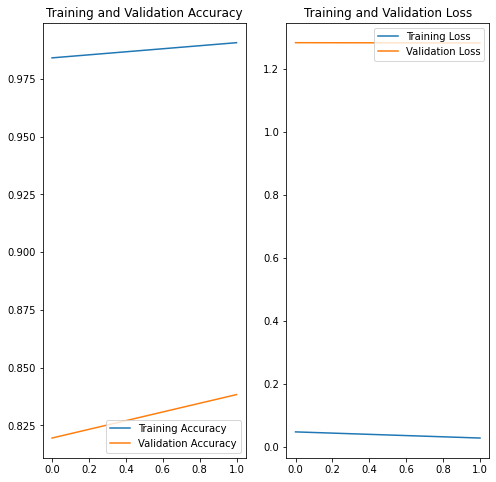

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<h1> Do fine Tuning </h1>

**Visualize the layers**

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)



**Freez desired layers**

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_ft.layers[:249]:
   layer.trainable = False
for layer in model_ft.layers[249:]:
   layer.trainable = True


model_ft.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model_ft.fit(...)

**Preform Fine Tuning**

In [ ]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
epochs=2
history = model_ft.fit(
  train_ds, 
  validation_data=val_ds, 
  epochs=epochs
)

Epoch 1/2
34/34 [==============================] - 223s 6s/step - loss: 0.0482 - accuracy: 0.9841 - val_loss: 1.2837 - val_accuracy: 0.8195
Epoch 2/2
34/34 [==============================] - 216s 6s/step - loss: 0.0287 - accuracy: 0.9906 - val_loss: 1.2828 - val_accuracy: 0.8383


<h1>Predict new Data<h1>

In [ ]:
from tensorflow.python.tf2 import enabled

im_pd = '/content/drive/MyDrive/ImageClassification/flower_photos/daisy/286875003_f7c0e1882d.jpg'
im_ps = '/content/drive/MyDrive/ImageClassification/flower_photos/sunflowers/200557981_f800fa1af9.jpg'

img = tf.keras.utils.load_img(
    im_ps,
    #color_mode = "grayscale", 
    target_size=(img_height, img_width),
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_ft.predict(img_array)
#score = tf.nn.softmax(predictions[0])

print(predictions)
if predictions>0.5:
  print('image belongs to class sunflower')
else:
  print('image belongs to class daisy')

[[0.99999976]]
image belongs to class sunflower
